In [17]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import random as r
import torch.nn.functional as F
import torchvision.transforms as T
from torch import nn, optim
from torchvision import datasets, transforms
from PIL import Image
from torch.utils.data import DataLoader
from torch.autograd import Variable
from sklearn import metrics
from sklearn.metrics import confusion_matrix

device = "cuda"

# Data & Preprocessing


making the data loders

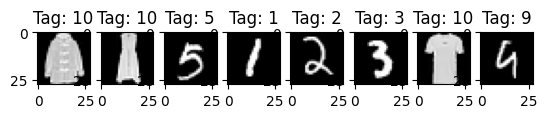

In [18]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,)),])

#Downloding the data sets
train_and_valid_set = datasets.MNIST(root="MNIST", download=True, train=True, transform=transform)
Fashion = datasets.FashionMNIST(root="FashionMNIST", download=True, train=False, transform=transform, target_transform=T.Lambda(lambda y:10))
test_set = datasets.MNIST(root="MNIST", download=True, train=False, transform=transform)

train, valid = torch.utils.data.random_split(train_and_valid_set,[int(0.8*len(train_and_valid_set)),int(0.2*len(train_and_valid_set))])
test =test_set + Fashion

#Creating dataloders
test_dataloader = DataLoader(test, batch_size=64, shuffle=True)
baseline_test_dataloader = DataLoader(test_set, batch_size=64, shuffle=True)
train_dataloader = DataLoader(train, batch_size=64, shuffle=True)
validation_dataloader = DataLoader(valid, batch_size=64, shuffle=True)

#Print data from the test pictures
fig, axes = plt.subplots(1,8)
for i in range(len(axes)):
    rnd = int(r.random() * 15000) #len is 20000 i dont want 50-50
    axes[i].imshow(test[rnd][0].permute(1, 2, 0), cmap="gray")
    axes[i].set_title("Tag: " + str(test[rnd][1]))
plt.show()

#Models

In [19]:
class ConvNet(nn.Module):

    #Calculate the dimensions of the image after each layer
    #w stands for width , s stand for Stride , k for Kernel , p for Padding
    def newWidth(self,w,s,k,p):
        return int((w-k+p*2)/s+1)

    def __init__(self, kernel):
        super(ConvNet, self).__init__()
        width = 28
        self.conv1 = nn.Conv2d(in_channels =1, out_channels = 10, kernel_size = kernel, stride=1, padding=1, padding_mode='zeros')
        width = self.newWidth(width,1,kernel,1)

        self.maxPooling1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        width = self.newWidth(width,2,2,0)

        self.conv2 = nn.Conv2d(in_channels =10, out_channels = 20, kernel_size = kernel, stride=1, padding=1, padding_mode='zeros')
        width = self.newWidth(width,1,kernel,1)

        self.maxPooling2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        width = self.newWidth(width,2,2,0)

        self.hidden1 = nn.Linear(width*width*20, 64)
        self.hidden2 = nn.Linear(64, 10)

    def forward(self, x, bs=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxPooling1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxPooling2(x)
        x = torch.flatten(x,1)
        if bs :
            x = torch.flatten(x)
        x = self.hidden1(x)
        x = F.relu(x)
        x = self.hidden2(x)
        return x

convNet = ConvNet(5).to(device)
print(convNet)

ConvNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (maxPooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (maxPooling2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (hidden1): Linear(in_features=500, out_features=64, bias=True)
  (hidden2): Linear(in_features=64, out_features=10, bias=True)
)


In [20]:
class ML_autoencoder(nn.Module):
    def __init__(self, code_size ,hiden1=400 ,hiden2=200 ,hiden3=64):
        super(ML_autoencoder, self).__init__()
        self.FC1 = nn.Linear(28 * 28 * 1 , hiden1)
        self.FC2 = nn.Linear(hiden1 , hiden2)
        self.FC3 = nn.Linear(hiden2 , hiden3)
        self.FC4 = nn.Linear(hiden3 , code_size)

        self.FC5 = nn.Linear(code_size , hiden3)
        self.FC6 = nn.Linear(hiden3 , hiden2)
        self.FC7 = nn.Linear(hiden2 , hiden1)
        self.FC8 = nn.Linear(hiden1 , 28 * 28 * 1)

        self.n_classes = 10
        #Add classification head
        #We tried to use it to help get better results before employing the final method.
        self.clf = nn.Sequential(
            nn.Linear(code_size, self.n_classes),
            nn.LogSoftmax(dim=1))

    def encoder(self,x):
        x = self.FC1(x)
        x = F.relu(x)
        x = self.FC2(x)
        x = F.relu(x)
        x = self.FC3(x)
        x = F.relu(x)
        x = self.FC4(x)
        x = F.relu(x)
        return x

    def decoder(self,x):
        x = self.FC5(x)
        x = F.relu(x)
        x = self.FC6(x)
        x = F.relu(x)
        x = self.FC7(x)
        x = F.relu(x)
        x = self.FC8(x)
        x = F.tanh(x)
        return x

    def forward(self, x):
        encoded_vector = self.encoder(x)
        recon = self.decoder(encoded_vector)
        preds = self.clf(encoded_vector)

        return recon, preds
model3 = ML_autoencoder(20).to(device)
print(model3)

ML_autoencoder(
  (FC1): Linear(in_features=784, out_features=400, bias=True)
  (FC2): Linear(in_features=400, out_features=200, bias=True)
  (FC3): Linear(in_features=200, out_features=64, bias=True)
  (FC4): Linear(in_features=64, out_features=20, bias=True)
  (FC5): Linear(in_features=20, out_features=64, bias=True)
  (FC6): Linear(in_features=64, out_features=200, bias=True)
  (FC7): Linear(in_features=200, out_features=400, bias=True)
  (FC8): Linear(in_features=400, out_features=784, bias=True)
  (clf): Sequential(
    (0): Linear(in_features=20, out_features=10, bias=True)
    (1): LogSoftmax(dim=1)
  )
)


#Training

creating the trianing functions

In [21]:
def trainML_AE(model, trainloader):
    learning_rate = 0.0001
    criterion = nn.MSELoss(reduction='sum')
    clf_criterion = nn.NLLLoss()

    optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=1e-5)
    # a list to hold the loss across epochs
    loss_train = []

    for epoch in range(45):
        loss_epoch = 0
        for data in trainloader:
            img, labels = data
            img = img.view(img.size(0), -1)
            img = Variable(img).to(device)
            labels = labels.to(device)
            # ===================forward=====================
            recon, preds =  model(img)
            loss = criterion(recon, img)
            clf_loss = clf_criterion(preds, labels)
            loss = loss + clf_loss
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_epoch += loss.item()
        #divide by number of batchs
        loss_epoch = loss_epoch / len(trainloader)
        loss_train.append(loss_epoch)

    plt.plot(loss_train,color='blue',label='batch loss')
    plt.xlabel("Epoch")
    plt.ylabel("batch loss")
    plt.grid()
    plt.title("train autoencoder Loss")
    plt.legend()
    plt.show()

    model.eval()
    return model


In [22]:
def train_model( model, dataloaders, optimizer):
    criterion = nn.CrossEntropyLoss()
    lossHistory = {'train':list() ,'val': list()}
    AccHistory = {'train':list() ,'val': list()}
    for epoch in range(45):
        running_loss = 0.0
        for type1 in ["train","val"]:
            if type1 == "train":
            # Set model to training mode
                model.train()
            else:
                # Set model to evaluate mode
                model.eval()
            running_loss = 0.0
            predictionAcc =0.0
            for i, data in enumerate(dataloaders[type1], 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                # mode to device/cuda
                inputs, labels = inputs.to(device), labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                outputs = model(inputs)
                _, prediction = torch.max(outputs, 1)
                predictionAcc += torch.sum(prediction == labels.data).cpu()

                loss = criterion(outputs, labels)
                if(type1 == "train"):
                    loss.backward()
                    optimizer.step()

                # print statistics
                running_loss += loss.item() * inputs.size(0)
            AccHistory[type1].append((predictionAcc.double() / dataset_sizes[type1]) * 100)
            lossHistory[type1].append(running_loss/dataset_sizes[type1])


    params = str(model.conv2.kernel_size)
    params ="Model With Kernel Size: " +params
    plt.plot(lossHistory["train"],color='blue',label='train')
    plt.plot(lossHistory["val"],color='green',label='validation')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.title("Loss For The CNN "+params)
    plt.legend()
    plt.show()

    plt.plot(AccHistory["train"],color='blue',label='train')
    plt.plot(AccHistory["val"],color='green',label='validation')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.title("Accuracy For The CNN "+params)
    plt.legend()
    plt.show()

    model.eval()
    return model

training the model

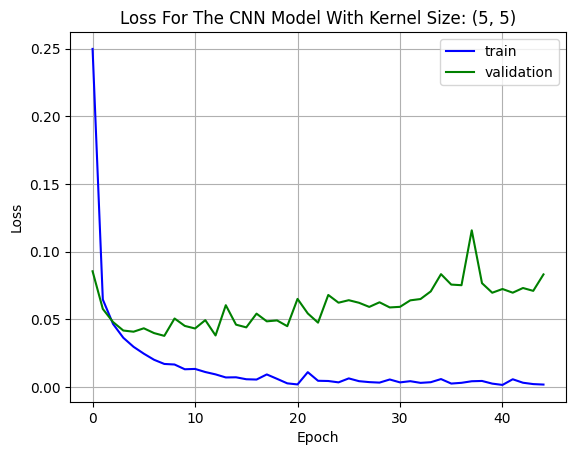

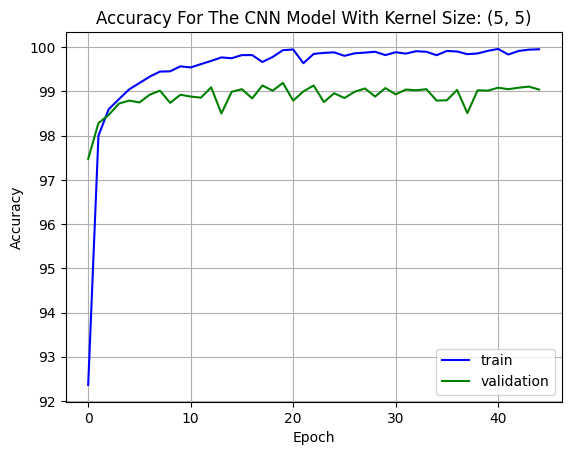

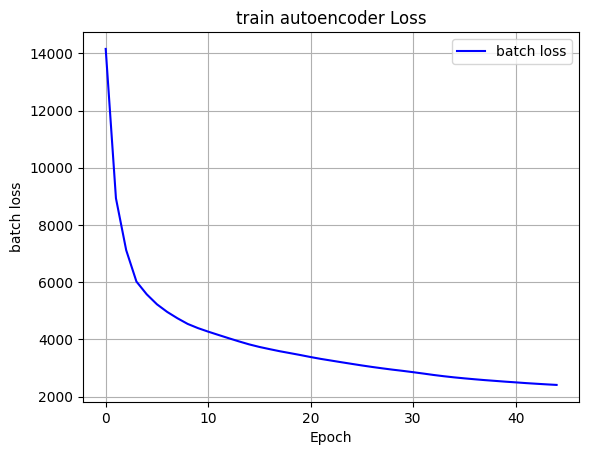

In [23]:
#Combine data loaders to fit the training function.
dataloaders = {'train':train_dataloader ,  'val': validation_dataloader}
dataset_sizes = {'train':len(train) ,'val': len(valid)}
optimizer1=optim.Adam(convNet.parameters(), lr=0.001)
net_long = convNet.to(device)
convNet = train_model(convNet , dataloaders=dataloaders , optimizer=optimizer1)
model3 = ML_autoencoder(20).to(device) #20 is code size, can be hard coded into the modelֿ
#High code size implies the possibility of overfitting, which is acceptable for this task.
model3 = trainML_AE(model3, train_dataloader)

#Evaluation

The baseline Final Model accracy and he's confusion matrix
The Accuracy of the Final Model Is 95.93 %


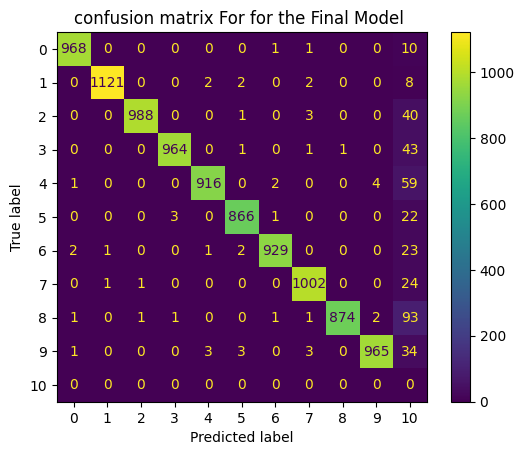

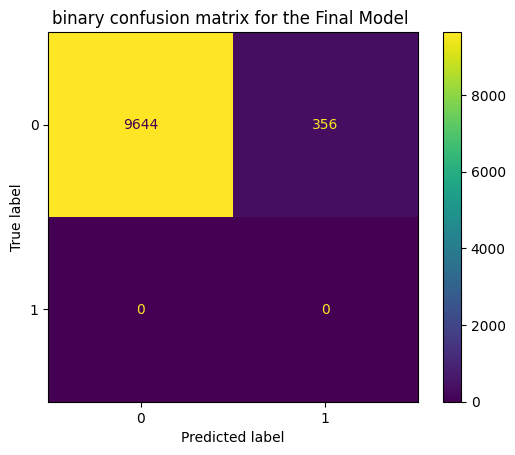

The OSR Final Model accracy and he's confusion matrix
The Accuracy of the Final Model Is 95.165 %


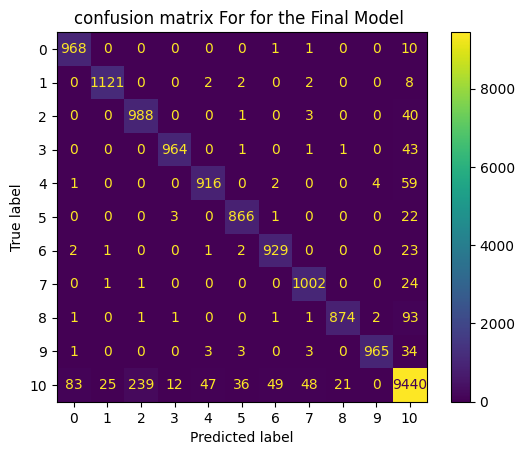

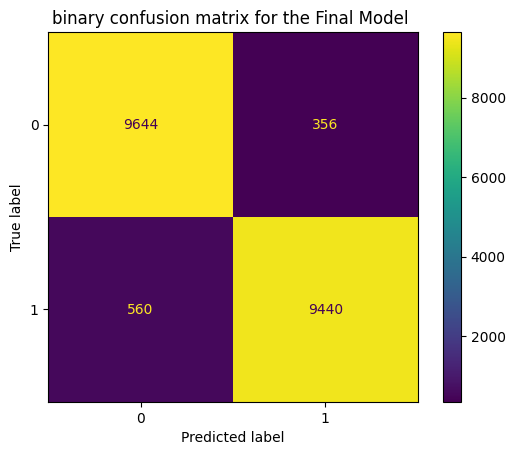

In [24]:
#Test the model and generate a confusion matrix for the results.
def test_model(model, ae, dataloaders,size):
    predictionAcc=0
    pred=[]
    target=[]
    pred_odd=[]
    target_odd=[]
    criterion = nn.MSELoss(reduction='sum')
    for i, data in enumerate(dataloaders, 0):
        inputs, labels = data
        #For each picture.
        for input1,lable1 in zip(inputs,labels):
            #Put the picture in the autoencoder.
            AEinput, preds= ae(input1.view(1,28*28).to(device))
            AEinput = AEinput.view(1,28,28)
            AEinput = AEinput.to(device)
            input1 = input1.to(device)
            #Check the difference between the original image and the image obtained through the autoencoder.
            loss = criterion(input1 , AEinput)
            #If the loss is low, Check what number it is.
            if(loss < 155):
                #Loss is very low; simply input it into the CNN.
                if(loss < 35):
                    CNN_Pred0 = model(input1,bs=True)
                    _ , prediction = torch.max(CNN_Pred0,dim=0)
                #If the loss is not sufficiently low, input both the original image and the autoencoder-generated image into the CNN.
                #If there is a match, it represents a number; otherwise, it is considered unknown.
                else:
                    CNN_Pred1 = model(AEinput.view(1,28,28),bs=True)
                    _ , AEprediction = torch.max(CNN_Pred1,dim=0)
                    CNN_Pred0 = model(input1,bs=True)
                    _ , prediction1 = torch.max(CNN_Pred0,dim=0)
                    if (AEprediction != prediction1):
                        prediction = torch.tensor(10)
                    else:
                        prediction = AEprediction

            #Else it is considered unknown.
            else:
                prediction = torch.tensor(10)

            #Collecting data for the confusion matrix.
            predictionAcc += torch.sum(prediction == lable1).cpu()
            pred.append(prediction.item())
            target.append(lable1.item())
            if(lable1<=9):
                target_odd.append(0)
            else:
                target_odd.append(1)
            if(prediction<=9):
                pred_odd.append(0)
            else:
                pred_odd.append(1)


    print("The Accuracy of the Final Model Is",float((predictionAcc.double() / size * 100)),"%")
    confusion_matrix = metrics.confusion_matrix(target, pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0,1,2,3,4,5,6,7,8,9,10])
    cm_display.plot()
    plt.title("confusion matrix For for the Final Model ")
    plt.show()

    confusion_matrix1 = metrics.confusion_matrix(target_odd, pred_odd)
    cm_display1 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix1, display_labels = [0,1])
    cm_display1.plot()
    plt.title("binary confusion matrix for the Final Model ")
    plt.show()

print("The baseline Final Model accracy and he's confusion matrix")
test_model(convNet , model3 , baseline_test_dataloader , len(test_set))
print("The OSR Final Model accracy and he's confusion matrix")
test_model(convNet , model3 , test_dataloader , len(test))



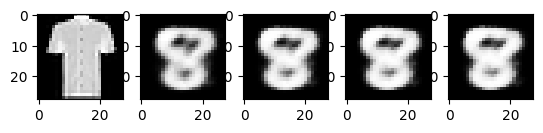

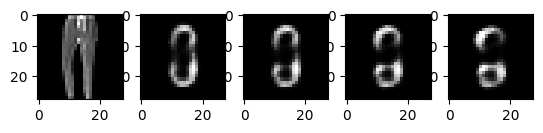

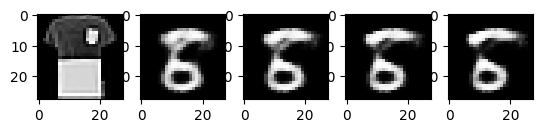

In [27]:
#Observing the transformation of some non-number pictures after a certain number of iterations in the autoencoder.
for i in range (1,4):
  fig1, axes1 = plt.subplots(1,5)

  pic, preds= model3(Fashion[40*i][0].view(1,28*28).to(device))
  pic1 , _ =model3(pic)
  pic2 , _ =model3(pic1)
  pic3 , _ =model3(pic2)
  pic4 , _ =model3(pic3)


  pic = pic.detach().cpu().reshape(28, 28)
  pic1= pic1.detach().cpu().reshape(28, 28)
  pic2= pic2.detach().cpu().reshape(28, 28)
  pic3= pic3.detach().cpu().reshape(28, 28)
  pic4= pic4.detach().cpu().reshape(28, 28)


  axes1[0].imshow(Fashion[40*i][0].permute(1, 2, 0), cmap="gray")
  axes1[1].imshow(pic, cmap="gray")
  axes1[2].imshow(pic1, cmap="gray")
  axes1[3].imshow(pic2, cmap="gray")
  axes1[4].imshow(pic3, cmap="gray")


  plt.show()

In [26]:
import torch

#Assuming you have a CNN model named "model3" that you want to download its weights.
#Step 1: Save the model's state dictionary to a file in the Colab environment.
#Replace 'model3_weights.pth' with the desired filename for the weights file.
torch.save(model3.state_dict(), 'model3_weights.pth')
torch.save(convNet.state_dict(), 'convNet_weights.pth')

